## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS

item_based и user_based рекоммендации основываются на user_item матрице, которая зачастую является сильно зазреженной и обладают следующими недостатками:
- Проблема холодного старта. Новодобавленные объекты никому не рекомендуются.
- Плохие предсказания для новых/нетипичных пользователей/объектов. Для необычных пользователей тяжело найти похожих пользователей и рекомендации не появляются.
- Тривиальность рекомендаций.
- Ресурсоемкость вычислений. Для того, чтобы делать предсказания нам нужно держать в памяти все оценки всех пользователей.

ALS алгоритм в свою очередь опирается на линейную алгебру, SVD разложение, а так же машинное обучение, для того чтобы найти/предсказать оценки. В добавок к этому, применяется регуляризация, для того, чтобы избежать переобучения.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 

- Выставленный рейтинг юзером для товара
- Приоритет товара для пользователя
- Количество просмотров этого товара на веб-сайте магазина

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)

Во-первых, матрица нам заранее неизвестна, поэтому мы не можем просто взять ее SVD разложение. Во-вторых, разложение не единственное, необходим подбор параметров

## Практическая часть


In [5]:
!pip install implicit

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

import warnings
warnings.filterwarnings("ignore")

In [68]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [39]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [52]:
def ALS(data_train, 
        data_test, 
        confidence=1,
        pivot_agg='count', 
        pivot_val='quantity',
        als_factors=44,
        als_regularization=0.001,
        als_iterations=15):
    
    '''
    data_train: pd.DataFrame
    data_test: pd.DataFrame
    pivot_agg: aggregation func which will be applied to the pivot table made using data_train
    pivot_val: column name of data_train which will be used as value in pivot table
    '''
    
    result = data_test.groupby('user_id')['item_id'].unique().reset_index()
    result.columns=['user_id', 'actual']
    result.head(2)
    
    popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

    top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

    # Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
    data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999
    
    
    user_item_matrix = pd.pivot_table(data_train, 
                                      index='user_id', 
                                      columns='item_id', 
                                      values=pivot_val, # Можно пробоват другие варианты
                                      aggfunc=pivot_agg, 
                                      fill_value=0
                                     )
    
    #CONFIDENCE LEVEL:

    user_item_matrix = user_item_matrix.astype(float) * confidence

    
    # переведем в формат saprse matrix
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()
    
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))

    model = AlternatingLeastSquares(factors=als_factors, 
                                regularization=als_iterations,
                                iterations=als_iterations, 
                                calculate_training_loss=True, 
                                use_gpu=False)
    
    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    
    def get_recommendations(user, model, N=5):
        res = [id_to_itemid[rec[0]] for rec in
                        model.recommend(userid=userid_to_id[user], 
                                        user_items=sparse_user_item,   # на вход user-item matrix
                                        N=N, 
                                        filter_already_liked_items=False, 
                                        filter_items=[itemid_to_id[999999]], 
                                        recalculate_user=True)]
        return res

    result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    
    result['precision_at_k'] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1)
    
    return result['precision_at_k'].mean()

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.

---

The confidence (c) is calculated as follows:

$c_{ui} = 1 + \alpha r_{ui}$

где:

$r_{ui}$ - это элемент user_item матрицы, а $\alpha$ это коэффициент уверенности. 

Попробуем посчитать precision_at_k с различными значениями $\alpha$

In [84]:
confidence_list = np.arange(0, 1, 0.05)
confidence_results = []

for confidence in confidence_list:
    confidence_results.append(ALS(data_train, data_test, confidence))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

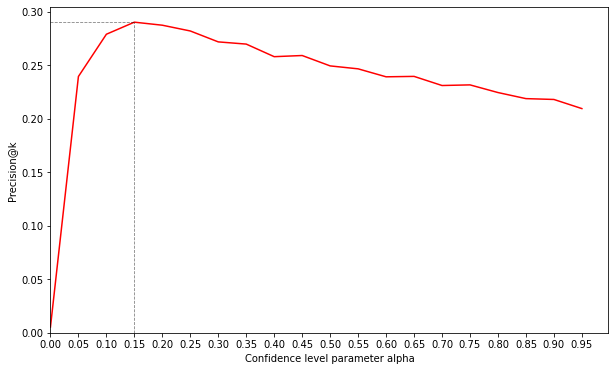

In [116]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=confidence_list, y=confidence_results, color='red')

confidence_df = pd.DataFrame.from_dict(dict(zip(confidence_list, confidence_results)), orient='index').reset_index()
confidence_df.rename(columns={'index':'alpha', 0:'precision_at_k'}, inplace=True)

best_result = confidence_df.sort_values('precision_at_k', ascending=False).head(1)


plt.plot([best_result['alpha'], best_result['alpha']],[0, best_result['precision_at_k']], 
         ls='dashed', 
         lw=0.8,
         alpha=0.5,
         c='black')

plt.plot([0, best_result['alpha']],[best_result['precision_at_k'], best_result['precision_at_k']], 
         ls='dashed',
         lw=0.8,
         alpha=0.5,
         c='black')

plt.plot()

plt.xlabel('Confidence level parameter alpha')
plt.xticks(confidence_list)
plt.ylabel('Precision@k')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show();

На удивление для меня, подбирая параметр $\alpha$ для $c_{ui} = 1 + \alpha r_{ui}$ наилучший показатель (как показано на рисунке выше) был подобран именно в интервале от 0 до 1. Естественно, я пробовал ставить достаточно большие значение alpha, но финальный precision был плохой. 

В итоге наилучший показатель $\alpha = 0.15$

Как работает параметр $\alpha$?:
Представим что у нас есть матрица user_item, состоящая из нулей, если пользователь не покупал продукт, и кол-ва купленных продуктов, в случае если он его покупал.

Тогда, если пользователь не приобретал продукт, коэффициент доверия будет равен:

$c_{ui} = 1 + \alpha r_{ui} = 1 + 0.15 * 0 = 1 $

А в случае, если продукт был куплен, к примеру, 5 раз, коэффициент доверия будет равен:

$c_{ui} = 1 + \alpha r_{ui} = 1 + 0.15 * 5 = 1.75 $



### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [142]:
hyperparams_df = pd.DataFrame(columns=['n_factors', 'lambda', 'time_sec', 'precision@k'])
n_factors = [50, 100, 200, 300, 500]
lambdas = [0.001, 0.01, 0.05, 0.1, 0.5]


for factor in n_factors:
    for l in lambdas:
        start_time = time.time()
        prec = ALS(data_train, 
                   data_test, 
                   confidence=float(best_result['alpha']), 
                   als_factors=factor,
                   als_regularization=l)
        execution_time = time.time() - start_time
        
        hyperparams_df = hyperparams_df.append({'n_factors': factor, 
                                                'lambda': l, 
                                                'time_sec': execution_time,
                                                'precision@k': prec}, 
                                                ignore_index=True)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [144]:
hyperparams_df.sort_values(by='precision@k', ascending=False)

,n_factors,lambda,time_sec,precision@k
23,500.0,0.100,256.915416,0.301665
24,500.0,0.500,261.899143,0.301469
21,500.0,0.010,255.399255,0.301077
20,500.0,0.001,255.960347,0.300881
22,500.0,0.050,258.130947,0.300784
19,300.0,0.500,111.833431,0.300490
10,200.0,0.001,67.282079,0.300490
15,300.0,0.001,543.786595,0.300196
13,200.0,0.100,66.048076,0.299804
18,300.0,0.100,112.028280,0.299706


**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

Во-первых, чем больше factor, тем больше времени требуется для оптимизации и поиска коэффициентов в эмбеддингах:

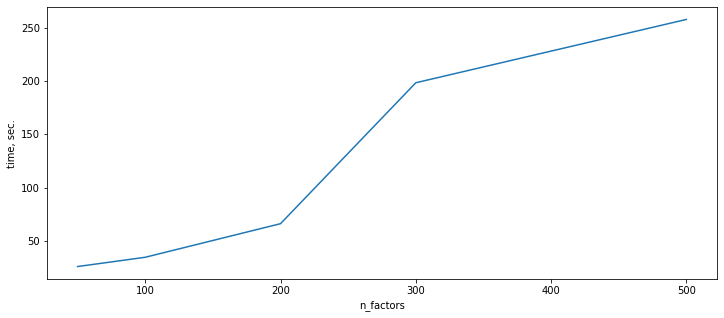

Коэффициент корреляции: 0.9626975239787354


In [166]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=hyperparams_df.groupby('n_factors')['time_sec'].mean().index, y=hyperparams_df.groupby('n_factors')['time_sec'].mean().values)
plt.ylabel('time, sec.')
plt.show();

print('Коэффициент корреляции:' ,np.corrcoef(hyperparams_df.groupby('n_factors')['time_sec'].mean().index, 
                  hyperparams_df.groupby('n_factors')['time_sec'].mean().values)[0][1])

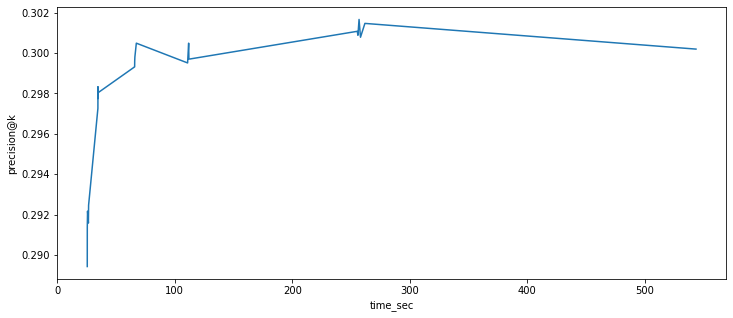

In [185]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=hyperparams_df['time_sec'], y=hyperparams_df['precision@k'])
plt.ylabel('precision@k')
plt.show();

Однако, если судить по затраченному времени, то после 60-ти секунд precision@k уходит на плато, поэтому нет смысла тратить много времени на обучение модели, так как precision@k не улучшается с течением времени.

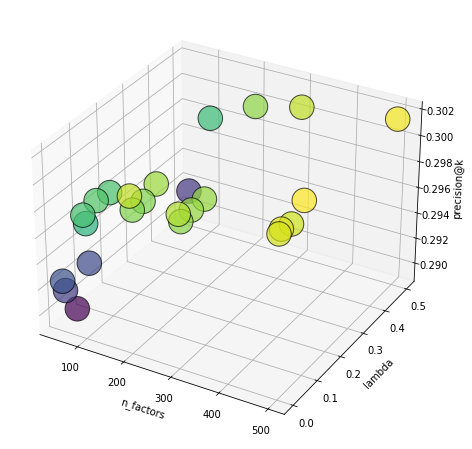

In [191]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hyperparams_df['n_factors'], 
           hyperparams_df['lambda'], 
           hyperparams_df['precision@k'],
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 600,
           c=hyperparams_df['precision@k'])
ax.set_xlabel('n_factors')
ax.set_ylabel('lambda')
ax.set_zlabel('precision@k')

plt.show();